In [1]:
from env import get_db_url
import wrangle_zillow
import model
import utilities

import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

from matplotlib import rcParams

alpha = 0.05
rcParams['figure.figsize'] = 16,8
sns.set(font_scale=1.5)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Acquire
df = wrangle_zillow.get_zillow()

Reading from csv file...


In [3]:
# Look at data
utilities.summary_info(df)

--- Shape: (77381, 67)
--- Descriptions
                   parcelid  airconditioningtypeid  architecturalstyletypeid  \
count             77,381.00              24,953.00                    206.00   
unique                  NaN                    NaN                       NaN   
top                     NaN                    NaN                       NaN   
freq                    NaN                    NaN                       NaN   
mean          13,007,150.51                   1.81                      7.39   
std            3,481,345.65                   2.97                      2.73   
min           10,711,855.00                   1.00                      2.00   
25%           11,538,305.00                   1.00                      7.00   
50%           12,531,568.00                   1.00                      7.00   
75%           14,211,831.00                   1.00                      7.00   
max          167,689,317.00                  13.00                     21.00   


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77381 entries, 0 to 77380
Data columns (total 67 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      77381 non-null  int64  
 1   airconditioningtypeid         24953 non-null  float64
 2   architecturalstyletypeid      206 non-null    float64
 3   basementsqft                  50 non-null     float64
 4   bathroomcnt                   77381 non-null  float64
 5   bedroomcnt                    77381 non-null  float64
 6   buildingclasstypeid           15 non-null     float64
 7   buildingqualitytypeid         49672 non-null  float64
 8   calculatedbathnbr             76772 non-null  float64
 9   decktypeid                    614 non-null    float64
 10  finishedfloor1squarefeet      6023 non-null   float64
 11  calculatedfinishedsquarefeet  77185 non-null  float64
 12  finishedsquarefeet12          73749 non-null  float64
 13  f

In [4]:
# To limit to single_family_homes
df =wrangle_zillow.single_family_homes(df)
df.shape

(71548, 67)

### Prep Phase
- Data Prep: Column data types are appropriate for the data they contain
- Data Prep: Missing values are investigated and handled

In [5]:
utilities.missing_values_per_column(df)

,count,percent
buildingclasstypeid,71548,1.00
buildingclassdesc,71548,1.00
finishedsquarefeet15,71539,1.00
finishedsquarefeet13,71522,1.00
basementsqft,71498,1.00
storydesc,71498,1.00
storytypeid,71498,1.00
yardbuildingsqft26,71479,1.00
finishedsquarefeet6,71392,1.00
fireplaceflag,71376,1.00


In [6]:
#Remove unused columns
df = utilities.remove_columns(df, cols_to_remove = ['censustractandblock','finishedsquarefeet12','buildingqualitytypeid', 'heatingorsystemtypeid', 'propertyzoningdesc', 'heatingorsystemdesc', 'unitcnt'])
df.head().T

,0,1,2,3,4
parcelid,14297519,17052889,14186244,12177905,10887214
airconditioningtypeid,NaN,NaN,NaN,NaN,1.00
architecturalstyletypeid,NaN,NaN,NaN,NaN,NaN
basementsqft,NaN,NaN,NaN,NaN,NaN
bathroomcnt,3.50,1.00,2.00,3.00,3.00
bedroomcnt,4.00,2.00,3.00,4.00,3.00
buildingclasstypeid,NaN,NaN,NaN,NaN,NaN
calculatedbathnbr,3.50,1.00,2.00,3.00,3.00
decktypeid,NaN,NaN,NaN,NaN,NaN
finishedfloor1squarefeet,NaN,"1,465.00",NaN,NaN,NaN


In [7]:
# fix Lat/Longitude
df.latitude = df.latitude / 1_000_000
df.longitude = df.longitude / 1_000_000

In [8]:
#Missing values check
utilities.missing_values_per_column(df)

,count,percent
buildingclasstypeid,71548,1.00
buildingclassdesc,71548,1.00
finishedsquarefeet15,71539,1.00
finishedsquarefeet13,71522,1.00
basementsqft,71498,1.00
storydesc,71498,1.00
storytypeid,71498,1.00
yardbuildingsqft26,71479,1.00
finishedsquarefeet6,71392,1.00
fireplaceflag,71376,1.00


In [9]:
utilities.missing_values_per_row(df)

,n_cols_missing,percent_missing,row_counts
0,19,0.32,2
1,20,0.33,5
2,21,0.35,24
3,22,0.37,98
4,23,0.38,310
5,24,0.40,485
6,25,0.42,569
7,26,0.43,1069
8,27,0.45,2845
9,28,0.47,3929


In [10]:
df = utilities.handle_missing_values(df, prop_required_column = .5, prop_required_row = .5)
df.shape

(71548, 26)

In [11]:
df = utilities.data_prep(df, prop_required_column=.5, prop_required_row=.5)

(62210, 37)


In [12]:
df.isna().sum()

parcelid                          0
bathroomcnt                       0
bedroomcnt                        0
calculatedbathnbr                 0
calculatedfinishedsquarefeet      0
fips                              0
fullbathcnt                       0
latitude                          0
longitude                         0
lotsizesquarefeet                 0
propertycountylandusecode         0
propertylandusetypeid             0
rawcensustractandblock            0
regionidcity                      0
regionidcounty                    0
regionidzip                       0
roomcnt                           0
yearbuilt                         0
structuretaxvaluedollarcnt        0
taxvaluedollarcnt                 0
assessmentyear                    0
landtaxvaluedollarcnt             0
taxamount                         0
logerror                          0
transactiondate                   0
propertylandusedesc               0
county_code_bin                   0
county_code_bin_Orange Count

### Data Prep: Outliers are investigated and handled

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62210 entries, 0 to 77380
Data columns (total 37 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   parcelid                        62210 non-null  int64   
 1   bathroomcnt                     62210 non-null  float64 
 2   bedroomcnt                      62210 non-null  float64 
 3   calculatedbathnbr               62210 non-null  float64 
 4   calculatedfinishedsquarefeet    62210 non-null  float64 
 5   fips                            62210 non-null  float64 
 6   fullbathcnt                     62210 non-null  float64 
 7   latitude                        62210 non-null  float64 
 8   longitude                       62210 non-null  float64 
 9   lotsizesquarefeet               62210 non-null  float64 
 10  propertycountylandusecode       62210 non-null  object  
 11  propertylandusetypeid           62210 non-null  float64 
 12  rawcensustractandb

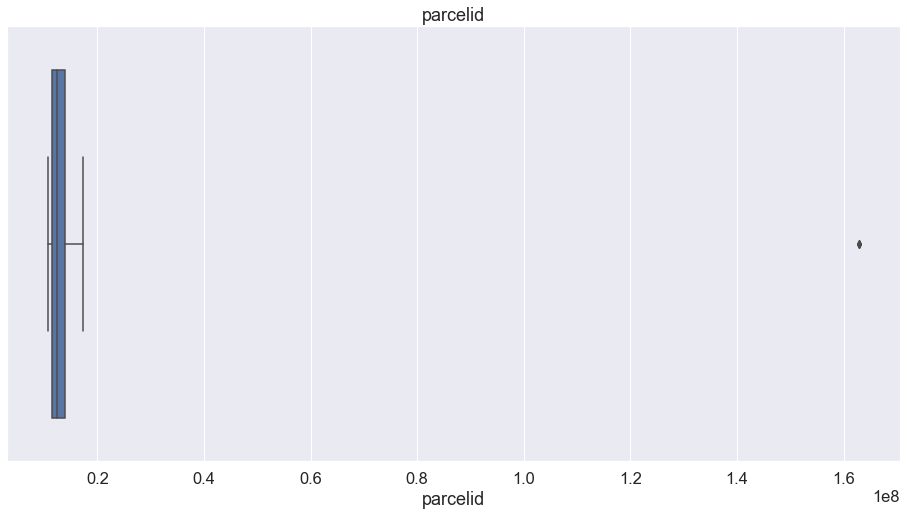

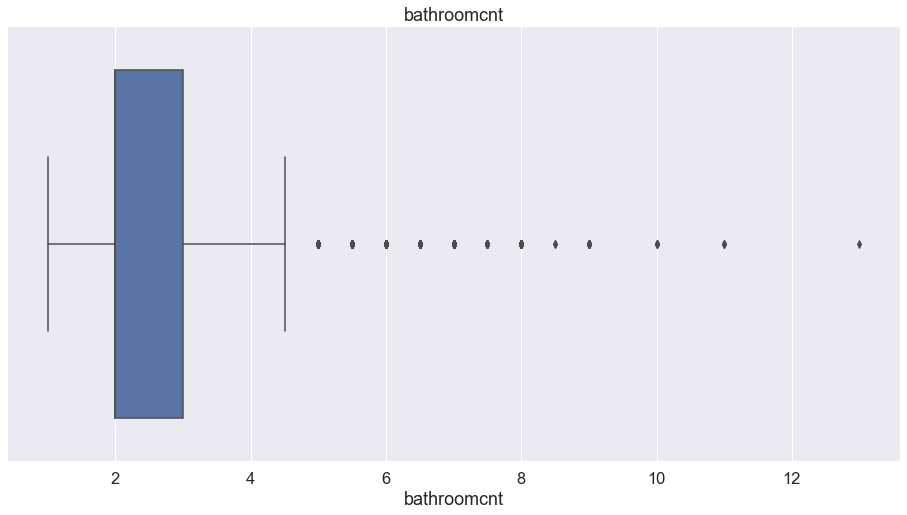

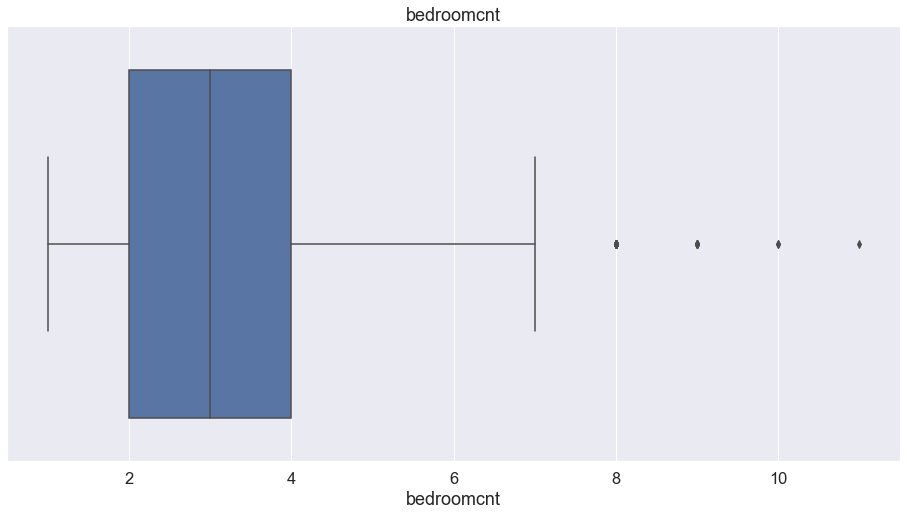

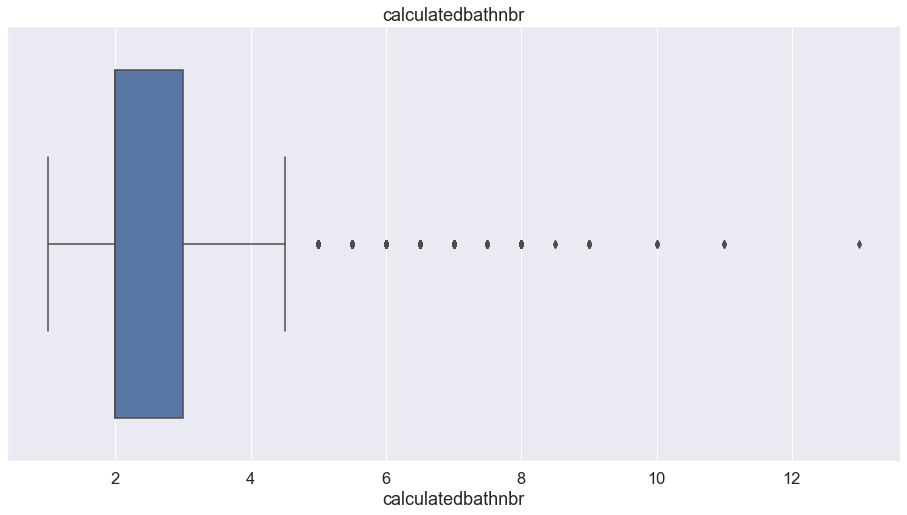

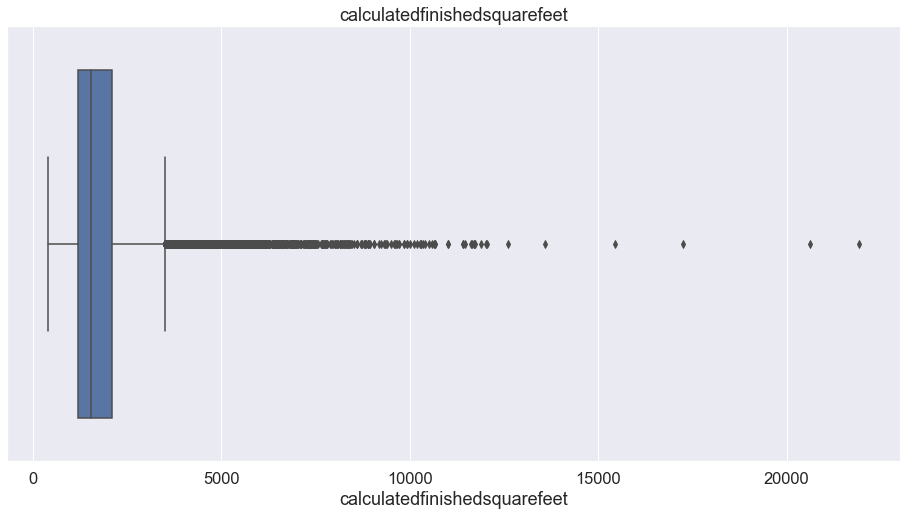

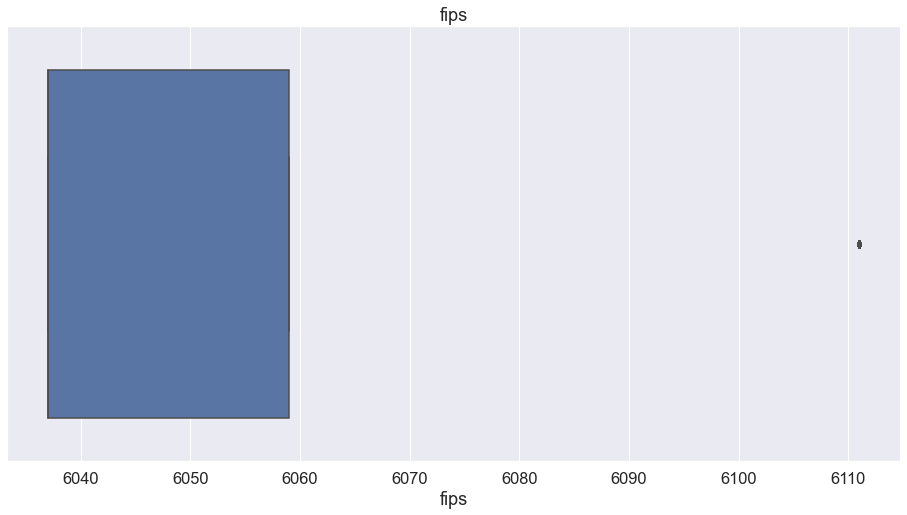

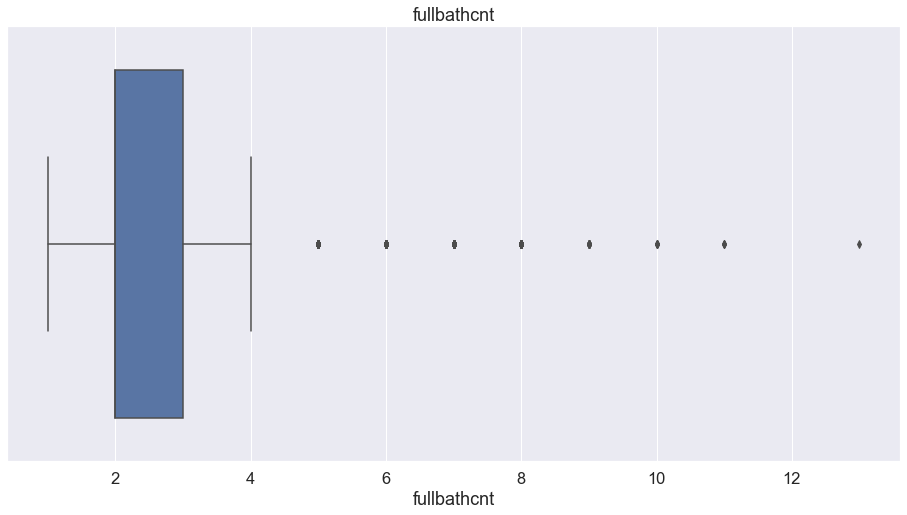

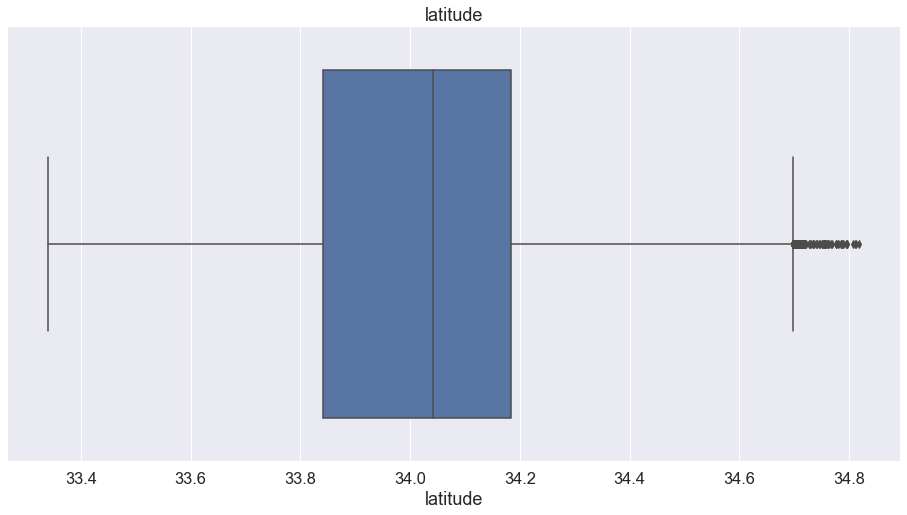

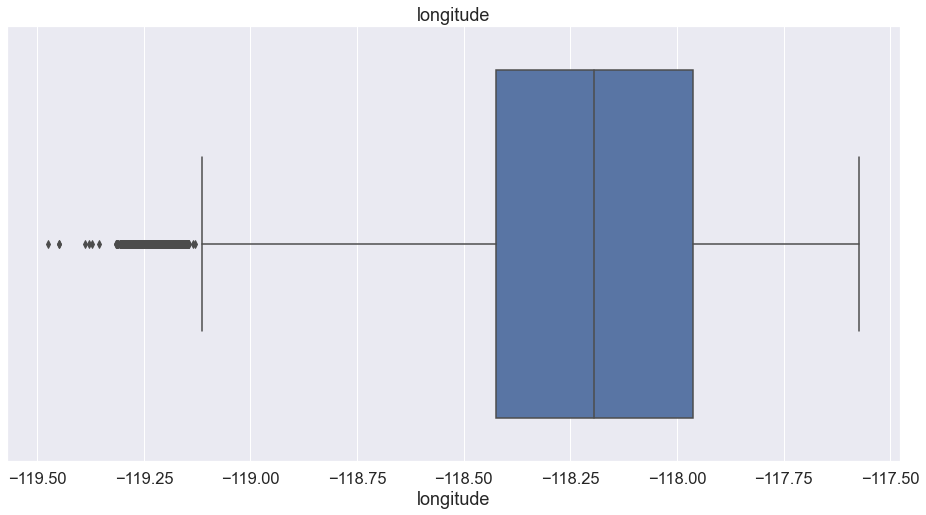

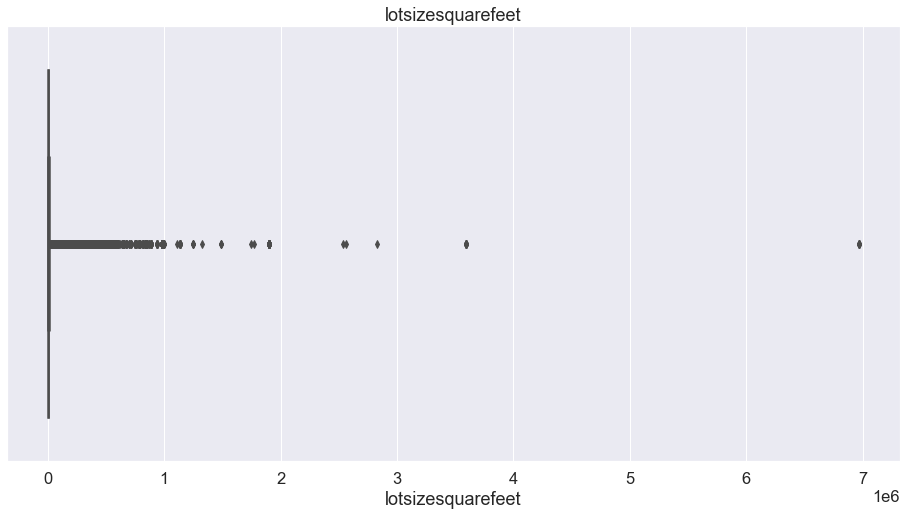

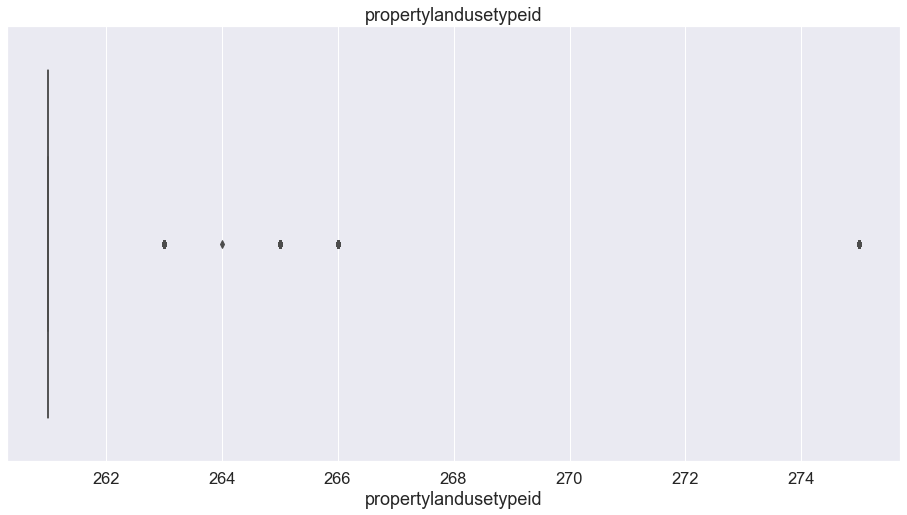

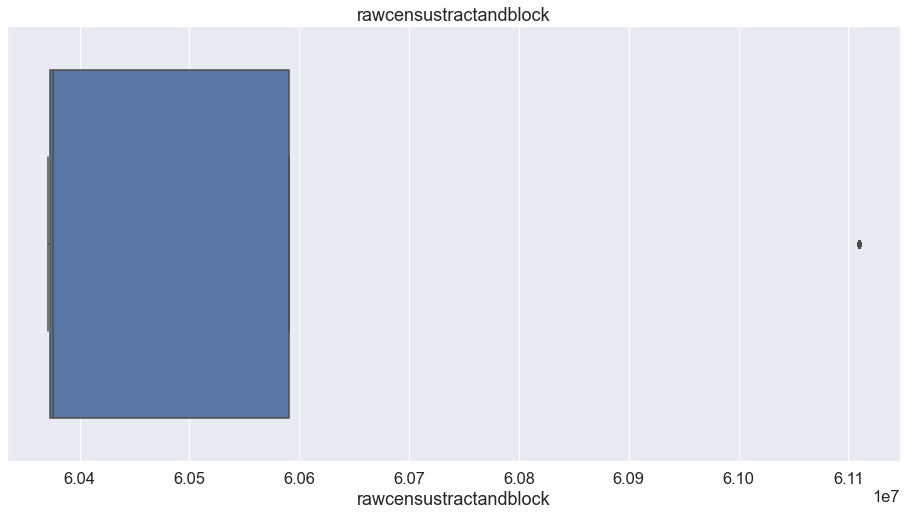

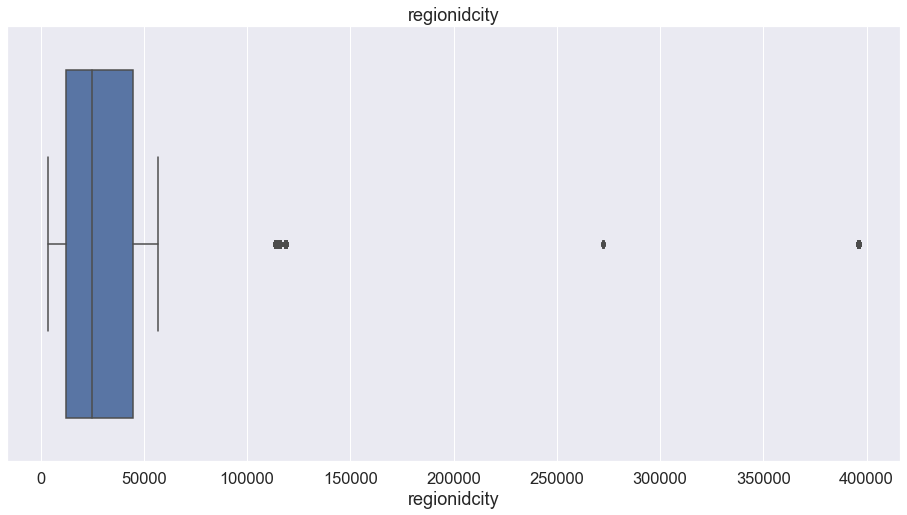

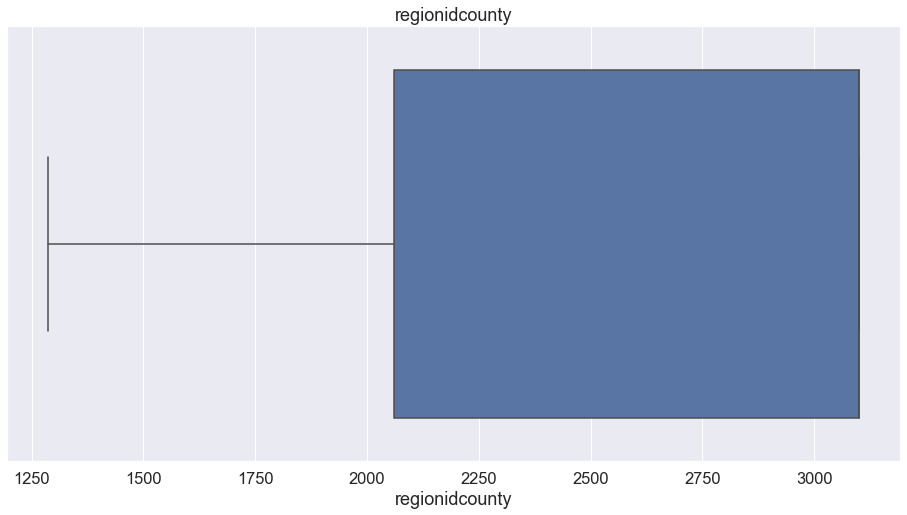

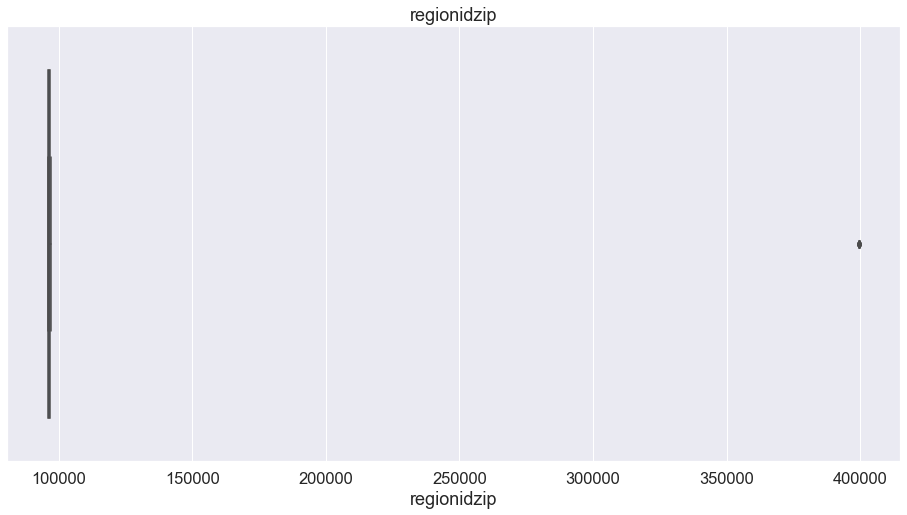

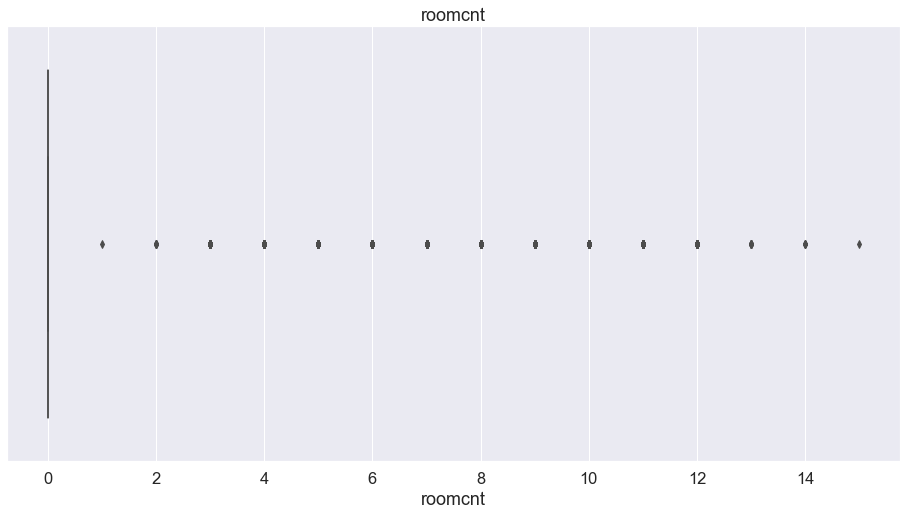

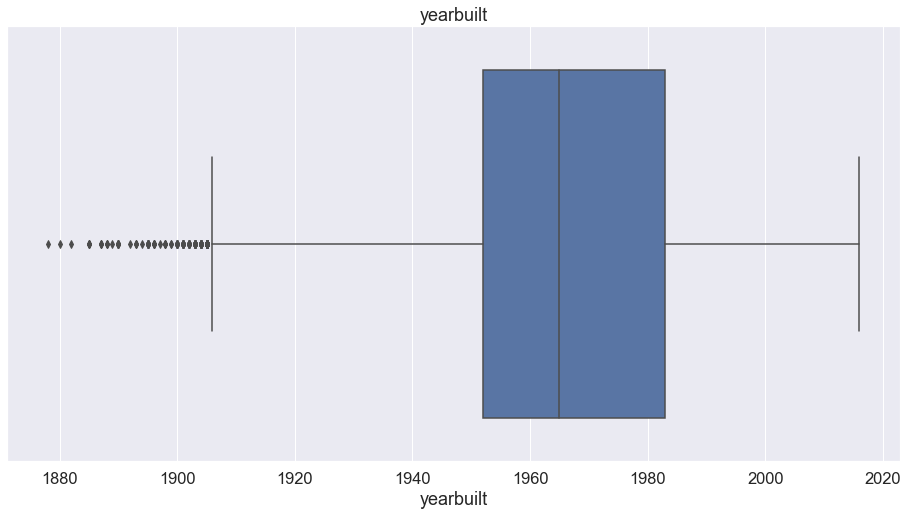

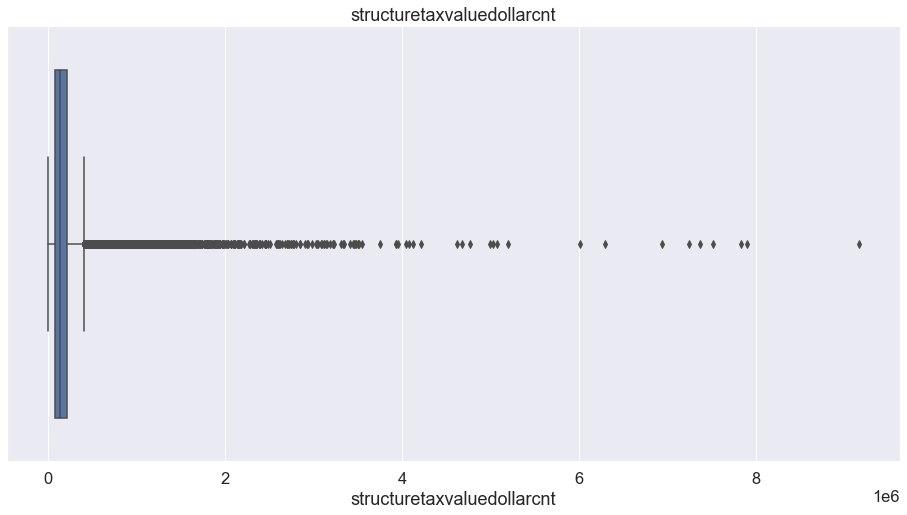

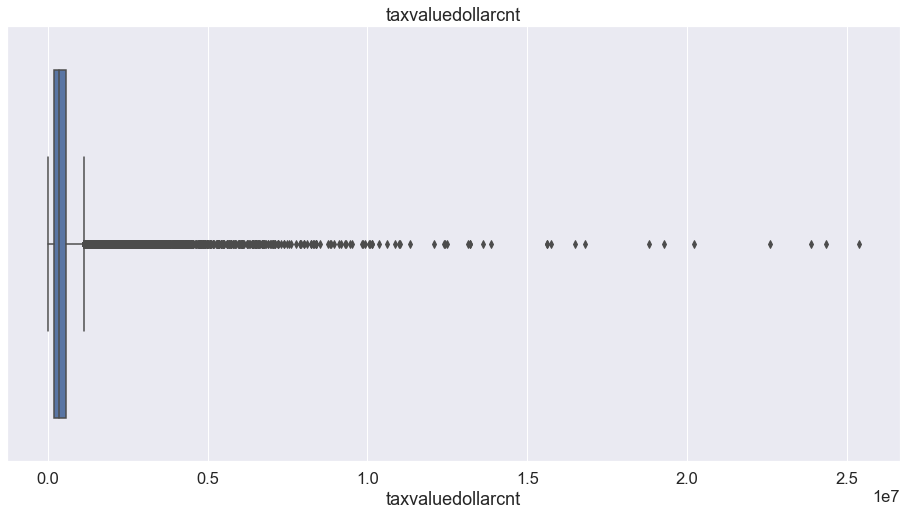

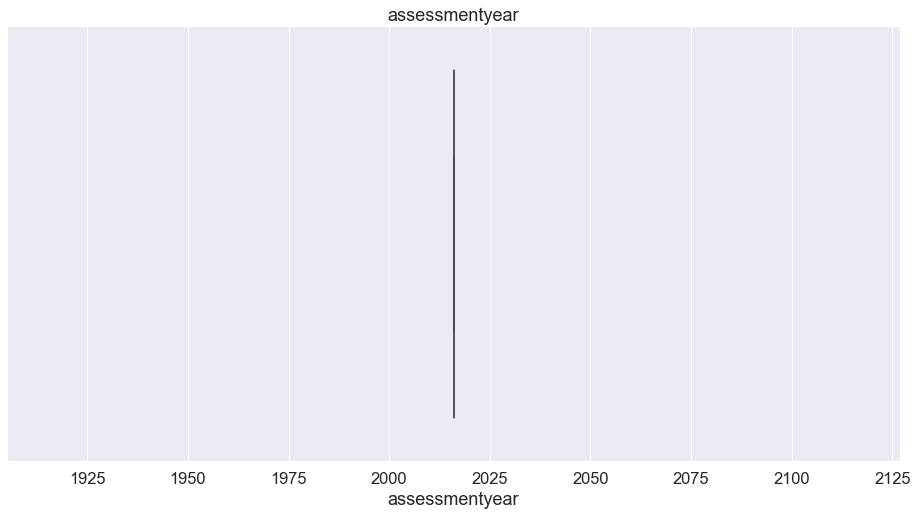

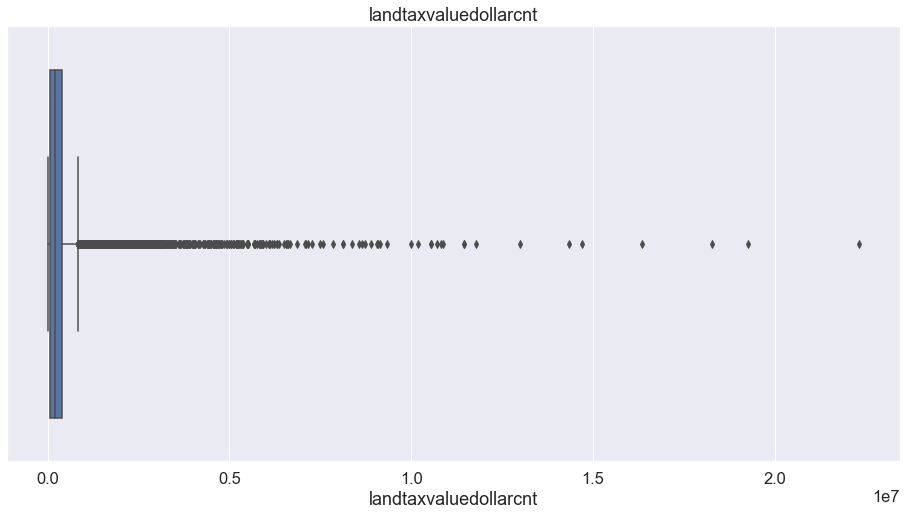

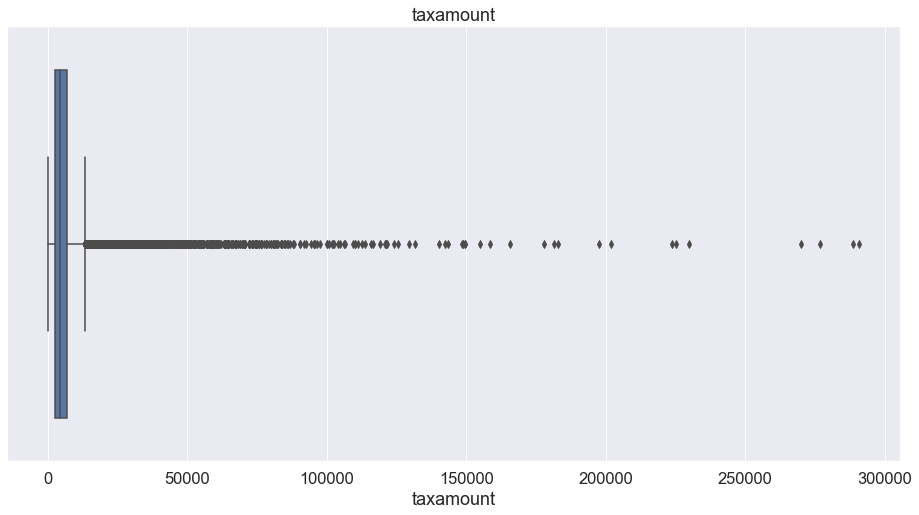

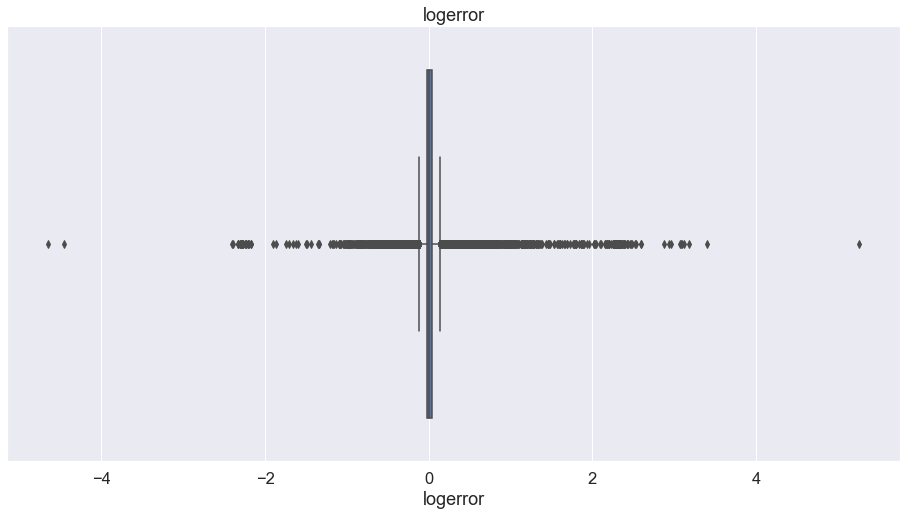

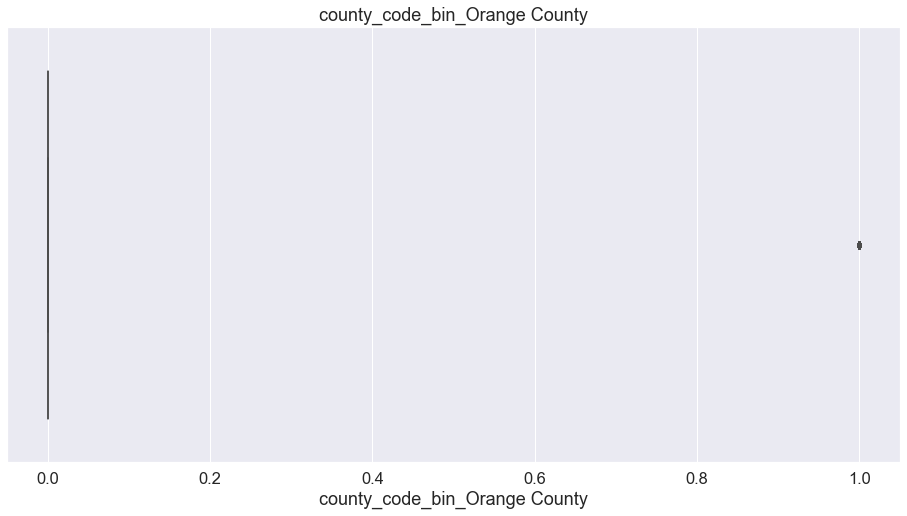

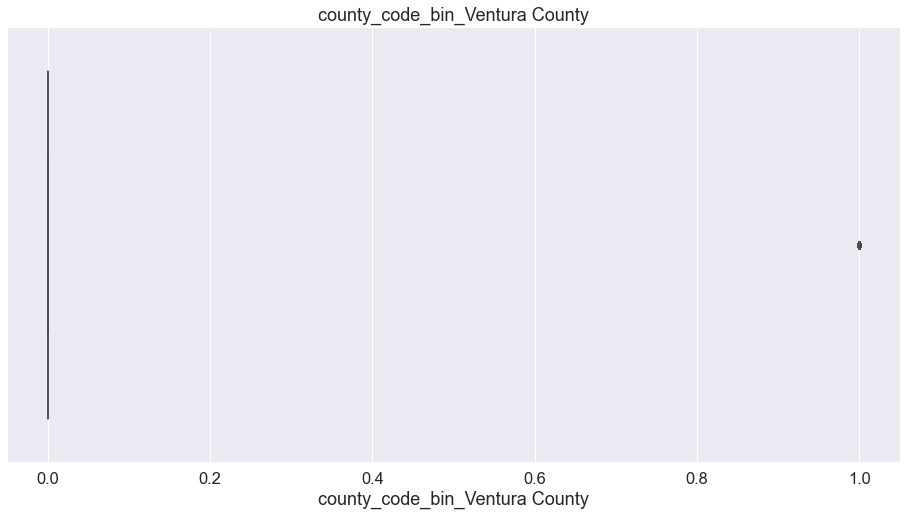

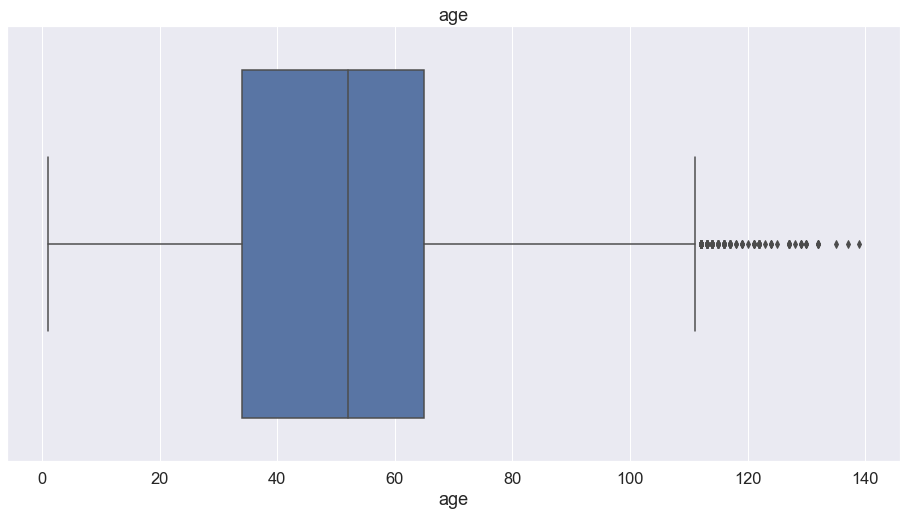

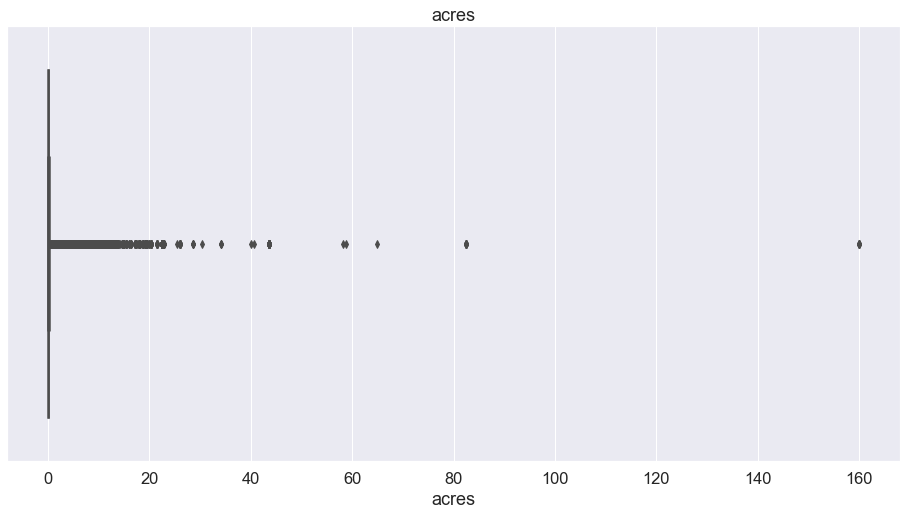

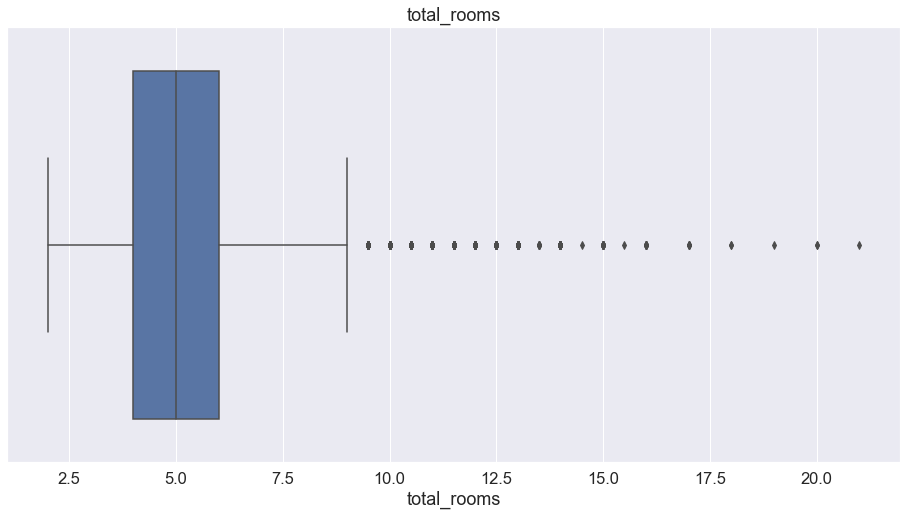

In [14]:
for col in df.select_dtypes('number'):
    sns.boxplot(df[col])
    plt.title(col)
    plt.show()

In [15]:
df.columns

Index(['parcelid', 'bathroomcnt', 'bedroomcnt', 'calculatedbathnbr',
       'calculatedfinishedsquarefeet', 'fips', 'fullbathcnt', 'latitude',
       'longitude', 'lotsizesquarefeet', 'propertycountylandusecode',
       'propertylandusetypeid', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidzip', 'roomcnt', 'yearbuilt',
       'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'assessmentyear',
       'landtaxvaluedollarcnt', 'taxamount', 'logerror', 'transactiondate',
       'propertylandusedesc', 'county_code_bin',
       'county_code_bin_Orange County', 'county_code_bin_Ventura County',
       'age', 'age_bin', 'home_sizes', 'acres', 'acres_bin', 'total_rooms',
       'bedroom_bins', 'bathroom_bins'],
      dtype='object')

In [16]:
#Columns to investigate upper/lower outliers
columns = ['bathroomcnt', 'bedroomcnt', 'calculatedbathnbr',
       'calculatedfinishedsquarefeet', 'fips', 'fullbathcnt', 'lotsizesquarefeet', 'propertycountylandusecode',
          'roomcnt', 'yearbuilt','structuretaxvaluedollarcnt', 'taxvaluedollarcnt']
# Upper outliers in roomcnt, lotsizesquarefeet, calculatedfinishedsquarefeet
#utitlities.get_upper_outliers('bathroomcnt',3.0).value_counts()

In [17]:
# Remove outliers in bath, bedroom, squarefeet, lotsize, and tax value using IQR approch. K=3.0 to limit data removal to <20% 
# Keeping it around the rubric lines of data 52,442 
df= utilities.remove_outliers(df, 3.0, ['bathroomcnt','bedroomcnt','calculatedfinishedsquarefeet','lotsizesquarefeet','taxvaluedollarcnt'])

Number of observations removed: 9979


In [18]:
# Add abs_logerror for future analysis
df['abs_logerror'] = abs(df["logerror"])

In [19]:
df.shape

(52231, 38)

## Exploration Phase
 - Key attributes
 - only particular data will be analyzed based on extensive analysis.  See this [link](https://github.com/bradgauvin/clustering-exercises/blob/main/explore_zillow.ipynb "Extensive Analysis") for extensive analysis.  Only some factors will be explored. 
 
 - Quick univariate analysis to understand data
 - Quick bivariate analysis on size variables and value variables
 
 ### Key questions for EDA
  - How do variables correlate?
  - How does `logerror` relate with geography? 
  - How do 'logerror' and `acres` vary by `county`?
  - What categories have statistically significant absolute log errors greater than overall mean?

#### Split Data

In [20]:
train, validate, test = wrangle_zillow.split_data(df)

Data split as follows: Train 56.00%, Validate 24.00%, Test 20.00%


In [21]:
train.shape, validate.shape, test.shape

((29248, 38), (12536, 38), (10447, 38))

In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29248 entries, 36995 to 38092
Data columns (total 38 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   parcelid                        29248 non-null  int64   
 1   bathroomcnt                     29248 non-null  float64 
 2   bedroomcnt                      29248 non-null  float64 
 3   calculatedbathnbr               29248 non-null  float64 
 4   calculatedfinishedsquarefeet    29248 non-null  float64 
 5   fips                            29248 non-null  float64 
 6   fullbathcnt                     29248 non-null  float64 
 7   latitude                        29248 non-null  float64 
 8   longitude                       29248 non-null  float64 
 9   lotsizesquarefeet               29248 non-null  float64 
 10  propertycountylandusecode       29248 non-null  object  
 11  propertylandusetypeid           29248 non-null  float64 
 12  rawcensustract

### Univariate Exploration

Text(0.5, 0, 'Log Error')

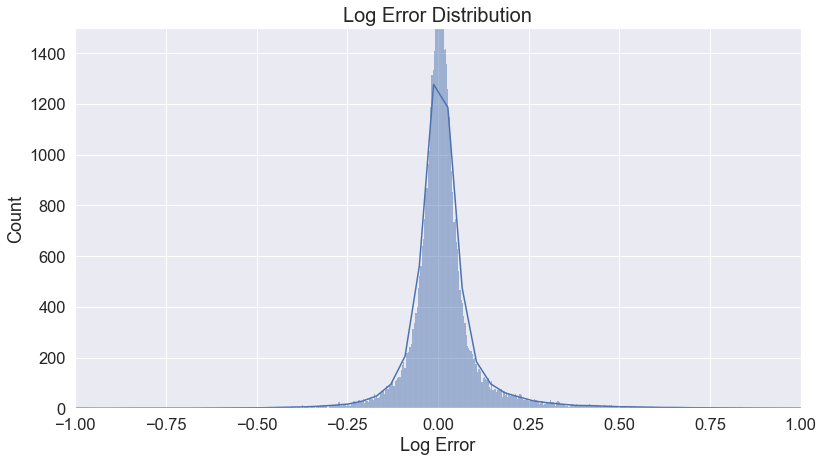

In [23]:
# Set size of figure
plt.figure(figsize = (13,7))
# Create histogram
ax = sns.histplot(data=df, x="logerror", kde=True)
# set x and y limits to 'zoom in'
ax.set(xlim = (-1, 1), ylim = (0, 1500)) # set the limits to the desired ones

plt.title('Log Error Distribution', fontsize=20)
plt.xlabel('Log Error')

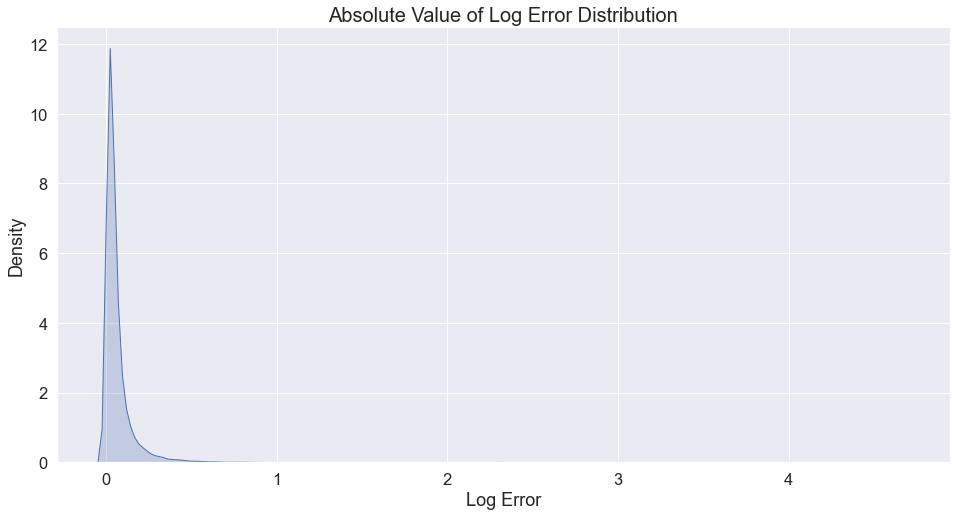

In [24]:
# absolute value of logerror
sns.kdeplot(df.logerror.abs(), shade=True)

plt.title('Absolute Value of Log Error Distribution', fontsize=20)
plt.xlabel('Log Error')

plt.show()

#### Bivariate

In [25]:
train['logerror_bins'] = pd.cut(train.logerror, [-5, -.2, -.05, .05, .2, 4])

<Figure size 936x504 with 0 Axes>

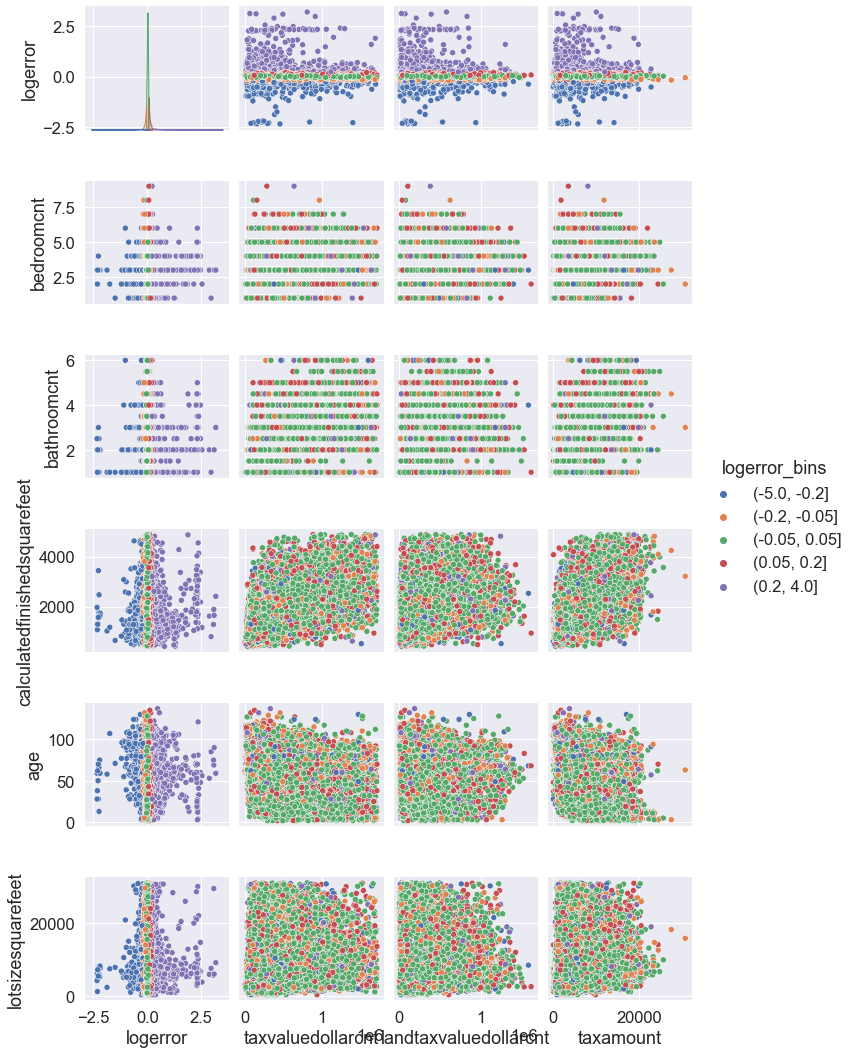

In [26]:
plt.figure(figsize = (13,7))
sns.pairplot(data = train, hue = 'logerror_bins', 
             x_vars = ['logerror', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount'],
             y_vars = ['logerror', 'bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'age', 'lotsizesquarefeet'])

### Takeaway
 - `Logerror` clusters possible in:
     - bedrooms
     - bathrooms
     - age
     - sqft dimentions (finished, lot, etc.)
     - value numbers (tax, land,taxed amount)

### Question 1:
### How do the variables correlate to target `logerror`?

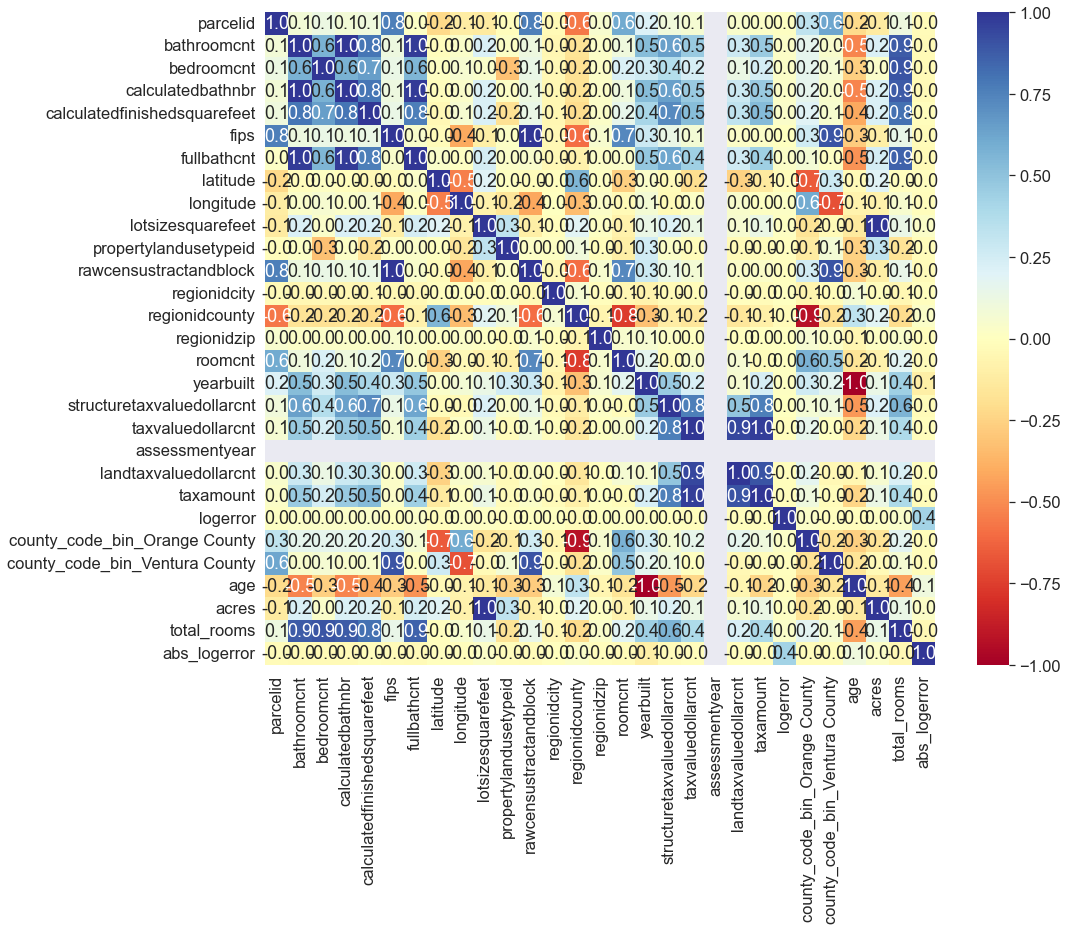

In [27]:
# Heatmap to display correlation of the features and logerror.
plt.figure(figsize = (15, 12))
sns.heatmap(df.corr(), cmap="RdYlBu", annot=True, fmt=".1f")
plt.show()

### Correlation Takeaway
- Nothing is related to `logerror`
- Possible correlations, just need to see it in different perspective.

### Question 2:
### How does `logerror` relate with geography?

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

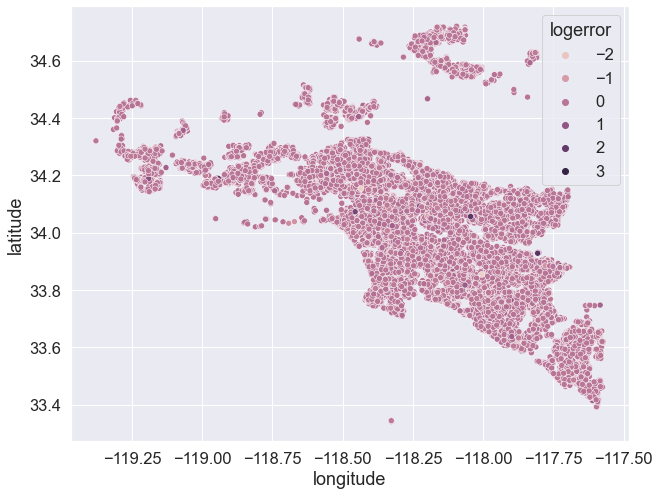

In [28]:
plt.figure(figsize=(10,8))
sns.scatterplot(data=train,x='longitude',y='latitude',hue='logerror')

### Question 3
### How do 'logerror' and acres vary by county?

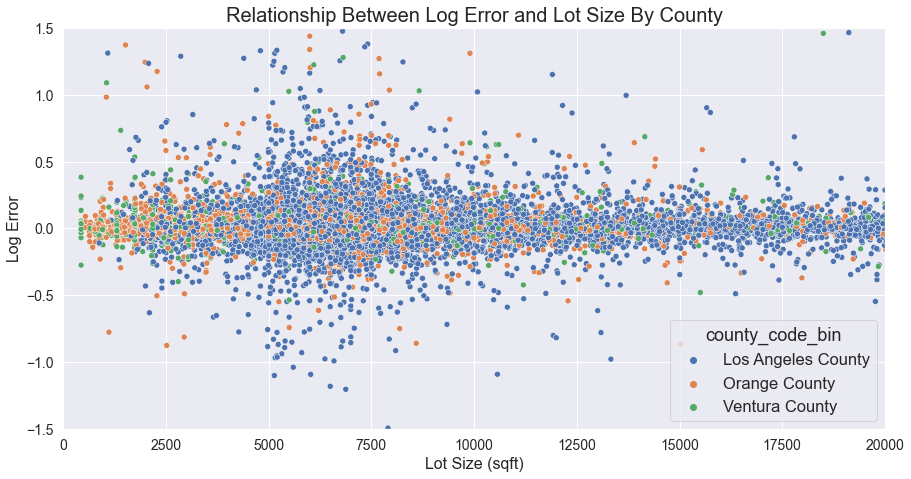

In [29]:
# acres didn't provide useful data... switched to lot sqft
x = train.lotsizesquarefeet
y = train.logerror
# Set size of figure
plt.figure(figsize = (13,7))
# Create scatterplot
ax = sns.scatterplot(data=train, x= x, y= y, hue="county_code_bin")
# set x and y limits to 'zoom in'
ax.set(xlim = (0, 20000), ylim= (-1.5,1.5)) # set the limits to the desired ones
# fit labels and legend
plt.title('Relationship Between Log Error and Lot Size By County', fontsize = 20)
plt.xlabel('Lot Size (sqft)', fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel('Log Error', fontsize = 16)


plt.tight_layout() 
plt.show()

<Figure size 936x504 with 0 Axes>

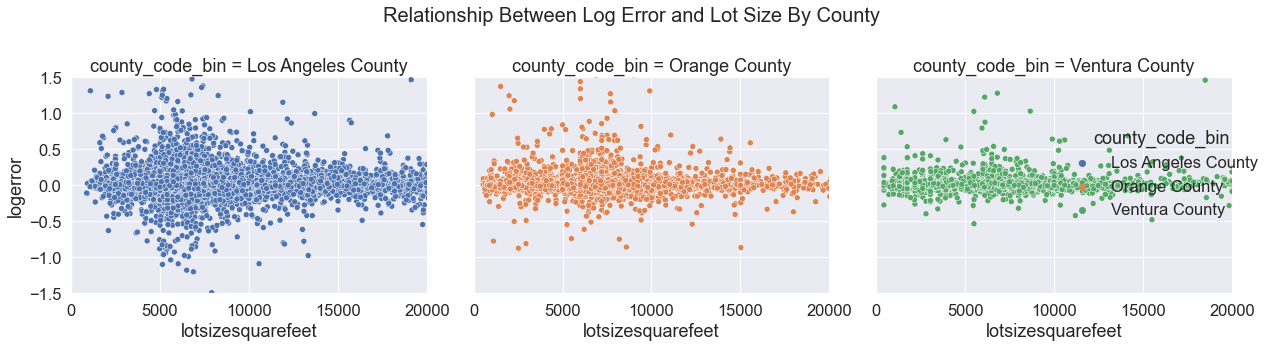

In [30]:
x = train.lotsizesquarefeet
y = train.logerror
# Set size of figure
plt.figure(figsize = (13,7))
# Create scatterplot
ax = sns.relplot(data=train, x= x, y= y, hue="county_code_bin", col="county_code_bin")
# set x and y limits to 'zoom in'
ax.set(xlim = (0, 20000), ylim= (-1.5,1.5)) # set the limits to the desired ones
# fit labels and legend
plt.suptitle('Relationship Between Log Error and Lot Size By County', fontsize = 20)
plt.yticks(fontsize = 14)
plt.ylabel('Log Error', fontsize = 16)


plt.tight_layout() 
plt.show()

#### Takeaway:
 - possible correlation as LA county has more logerrors
 - Possible difference between lot size... need hypothesis testing!

In [31]:
# H0 - There is no linear relationship between lot size and logerror.
# H1 - There is a linear realtionship between lot size and log error.
α = 0.05
r, p = stats.pearsonr(x,y)
print('r =', r)
print('p =', p)
if p < α:
    print("We reject the H0.")
else:
    print("We fail to reject the H0.")

r = 0.013285493817789484
p = 0.023080802668538656
We reject the H0.


#### What about by county?

In [32]:
train.groupby('county_code_bin').apply(lambda subset: stats.pearsonr(subset.lotsizesquarefeet, subset.logerror))

county_code_bin
Los Angeles County      (0.013027653222859363, 0.07207071907945671)
Orange County         (0.036183161376448204, 0.0017777038258515317)
Ventura County           (0.022230915366154406, 0.2457485602363546)
dtype: object

### Takeaway:
 - lot size and is variable for LA and Ventura county

### Question 4
### What is overall mean logerror?
 - Used as a baseline logerror overall
 - Needed to find which features are above this overall mean

In [33]:
# create abs_logerror column - need to add prior to split.
# train['abs_logerror'] = abs(train["logerror"])

In [34]:
overall_mean = train.abs_logerror.mean()
high_cols =[]
high_option = []
high_difference = []
option_means = []
option_sample_size=[]

print(f"Overall mean logerror: {overall_mean}")
for col in train.columns:
    if train[col].nunique()<10:
        for option in train[col].unique():
            if len(train[train[col]==option].abs_logerror)>2:
                t, p = stats.ttest_1samp(train[train[col]==option].abs_logerror, train.abs_logerror.mean())
                if p<alpha:
                    sample_mean = train[train[col]==option].abs_logerror.mean()
                    difference = sample_mean - overall_mean
                    sample_size = len(train[train[col]==option].logerror)
                    # print(f"For {col} - {option} the mean ({sample_mean:.4f}) differs significantly from overall mean by {difference:.4f}, sample size {len(train[train[col]==option].logerror)}")
                    
                    # Only saving those values with greater than average absolute log errors and decent sampel
                    if (difference>0) and (sample_size>100):
                        high_cols.append(col)
                        high_option.append(option)
                        high_difference.append(difference)
                        option_means.append(sample_mean)
                        option_sample_size.append(len(train[train[col]==option].logerror))

high_log_errors = pd.DataFrame(data = {'column':high_cols,
                                      'option': high_option,
                                      'mean_abs_log_error': option_means,
                                      'difference_from_overall': high_difference,
                                      'option_sample_size':option_sample_size})
                                      

Overall mean logerror: 0.06853391280914319


In [35]:
high_log_errors.sort_values(by='difference_from_overall', ascending=False).head(20)

,column,option,mean_abs_log_error,difference_from_overall,option_sample_size
14,logerror_bins,"(0.2, 4.0]",0.48,0.41,1263
11,logerror_bins,"(-5.0, -0.2]",0.40,0.33,597
7,home_sizes,Large: 4000 - 5999sqft,0.11,0.04,342
1,bedroomcnt,1.00,0.09,0.03,581
12,logerror_bins,"(0.05, 0.2]",0.09,0.03,4671
13,logerror_bins,"(-0.2, -0.05]",0.09,0.02,3520
3,fullbathcnt,1.00,0.09,0.02,6001
9,bedroom_bins,Small: 0-2 bedrooms,0.08,0.01,6550
4,fullbathcnt,4.00,0.08,0.01,1204
0,bedroomcnt,2.00,0.08,0.01,5969
